In [ ]:
# !pip install kerchunk

In [25]:
import pandas as pd
import pystac_client
import planetary_computer
import matplotlib.pyplot as plt
from matplotlib import animation
import warnings
import fsspec
import xarray as xr
from distributed import Client

## GOES-CMI example

Suppose you have some area and time of interest, for example where Hurricane Florence was for a 3-hour window (I got these values from the NCEI's [International Best Track Archive for Climate Stewardship](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00834), following [this example](https://github.com/pytroll/pytroll-examples/blob/main/satpy/GOES-16%20ABI%20-%20True%20Color%20Animation%20-%20Hurricane%20Florence.ipynb) from the PyTroll library).

In [26]:
bbox = [-67.27295684814453, 25.60000228881836, -61.79999923706055, 27.54236602783203]
start = pd.Timestamp("2018-09-11T13:00:00Z")
stop = pd.Timestamp("2018-09-11T15:40:00Z")

Given that knowledge, how do you find all the GOES images of interest? [NODD](https://www.noaa.gov/information-technology/open-data-dissemination) pushes GOES data to Azure Blob Storage, and the Planetary Computer team processes that data to

1. Create STAC metadata
2. Create derived Cloud-Optimized GeoTIFFs from the original NetCDF files

If you only had files in (locally or in Blob Storage), instead of STAC, you'd be listing directories and parsing filepaths which is slow and error prone. With STAC, it's (relatively) straightforward. The only domain-specific knowledge here is that GOES-CMI collects images in different "modes" and we're interested in the "MESOSCALE" type, which is documented on the [GOES-CMI dataset page](https://planetarycomputer.microsoft.com/dataset/goes-cmi).

In [27]:
%%time
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
search = catalog.search(
    collections=["goes-cmi"],
    bbox=bbox,
    datetime=[start, stop],
    query={"goes:image-type": {"eq": "MESOSCALE"}},
)
items = planetary_computer.sign(
    search.get_all_items()
)
len(items)

CPU times: user 707 ms, sys: 35.4 ms, total: 742 ms
Wall time: 1.79 s


160

So in a couple of seconds we've found all the STAC items matching our query. These items aren't the actual data, they're just metadata. They link to the actual data assets.

The assets are cloud-optimized GeoTIFFs, so we can quickly visualize them on a map:

In [28]:
import ipyleaflet
import requests
import shapely.geometry

item = items[-1]
tiles = requests.get(item.assets["tilejson"].href).json()["tiles"][0]
center = shapely.geometry.shape(item.geometry).centroid

m = ipyleaflet.Map(center=[center.y, center.x], zoom=4)
m.add_layer(ipyleaflet.TileLayer(url=tiles))
m.scroll_wheel_zoom = True
m

Map(center=[27.935409565996903, -66.2715962789556], controls=(ZoomControl(options=['position', 'zoom_in_text',…

And we have all the metadata necessary to load them into a datacube.

In [29]:
%%time
import odc.stac

# workaround odc-stac issue #87
warnings.filterwarnings("ignore", "Alias", category=UserWarning)
bands=["C01_2km", "C02_2km", "C03_2km"]
data = odc.stac.stac_load(items, bands=bands, chunks={})
data

CPU times: user 278 ms, sys: 9.57 ms, total: 287 ms
Wall time: 261 ms


<xarray.Dataset>
Dimensions:      (y: 499, x: 499, time: 160)
Coordinates:
  * y            (y) float64 3.366e+06 3.364e+06 ... 2.37e+06 2.368e+06
  * x            (x) float64 3.216e+05 3.236e+05 ... 1.318e+06 1.32e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2018-09-11T13:00:21 ... 2018-09-11T15:...
Data variables:
    C01_2km      (time, y, x) int16 dask.array<chunksize=(1, 499, 499), meta=np.ndarray>
    C02_2km      (time, y, x) int16 dask.array<chunksize=(1, 499, 499), meta=np.ndarray>
    C03_2km      (time, y, x) int16 dask.array<chunksize=(1, 499, 499), meta=np.ndarray>

So with a couple function calls and about a few seconds, we've gone from area / time of interest to a fully-formed datacube, ready for analysis.

Briefly, compare with NetCDF.

In [30]:
%%time
f = fsspec.open(items[0].assets["MCMIP-nc"].href).open()
ds_netcdf = xr.open_dataset(f, engine="h5netcdf", chunks={})

CPU times: user 690 ms, sys: 52 ms, total: 742 ms
Wall time: 896 ms


That's loaded the *metadata* for just a single NetCDF. It would take 2-3 minutes to get to the same point we're at with STAC + COGs.

In [31]:
key_to_common_name = {
    k: items[0].assets[k].to_dict()["eo:bands"][0]["common_name"] for k in bands
}

ds = data.rename(key_to_common_name)

In [32]:
green = 0.45 * ds["red"] + 0.1 * ds["nir09"] + 0.45 * ds["blue"]
green

<xarray.DataArray (time: 160, y: 499, x: 499)>
dask.array<add, shape=(160, 499, 499), dtype=float64, chunksize=(1, 499, 499), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3.366e+06 3.364e+06 ... 2.37e+06 2.368e+06
  * x            (x) float64 3.216e+05 3.236e+05 ... 1.318e+06 1.32e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2018-09-11T13:00:21 ... 2018-09-11T15:...

In [33]:
rgb = (
    ds.assign(green=green)
    .to_array(dim="band")
    .transpose("time", "band", "y", "x")
    .sel(band=["red", "green", "blue"])
)
rgb = rgb / rgb.max(dim=["band", "y", "x"])
rgb = (rgb ** (1 / 2.2)).clip(0, 1)
rgb

,Array,Chunk
Bytes,911.87 MiB,1.90 MiB
Shape,"(160, 3, 499, 499)","(1, 1, 499, 499)"
Count,6726 Tasks,480 Chunks
Type,float64,numpy.ndarray


In [34]:
import dask.distributed

client = dask.distributed.Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/taugspurger@microsoft.com/proxy/37215/status,
Dashboard: /user/taugspurger@microsoft.com/proxy/37215/status,Workers: 1
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: False
Comm: inproc://10.244.47.70/2651/10,Workers: 1
Dashboard: /user/taugspurger@microsoft.com/proxy/37215/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: inproc://10.244.47.70/2651/13,Total threads: 4
Dashboard: /user/taugspurger@microsoft.com/proxy/46021/status,Memory: 32.00 GiB
Nanny: None,


In [35]:
%time rgb = rgb.compute()

CPU times: user 1min 10s, sys: 27.9 s, total: 1min 38s
Wall time: 48.7 s


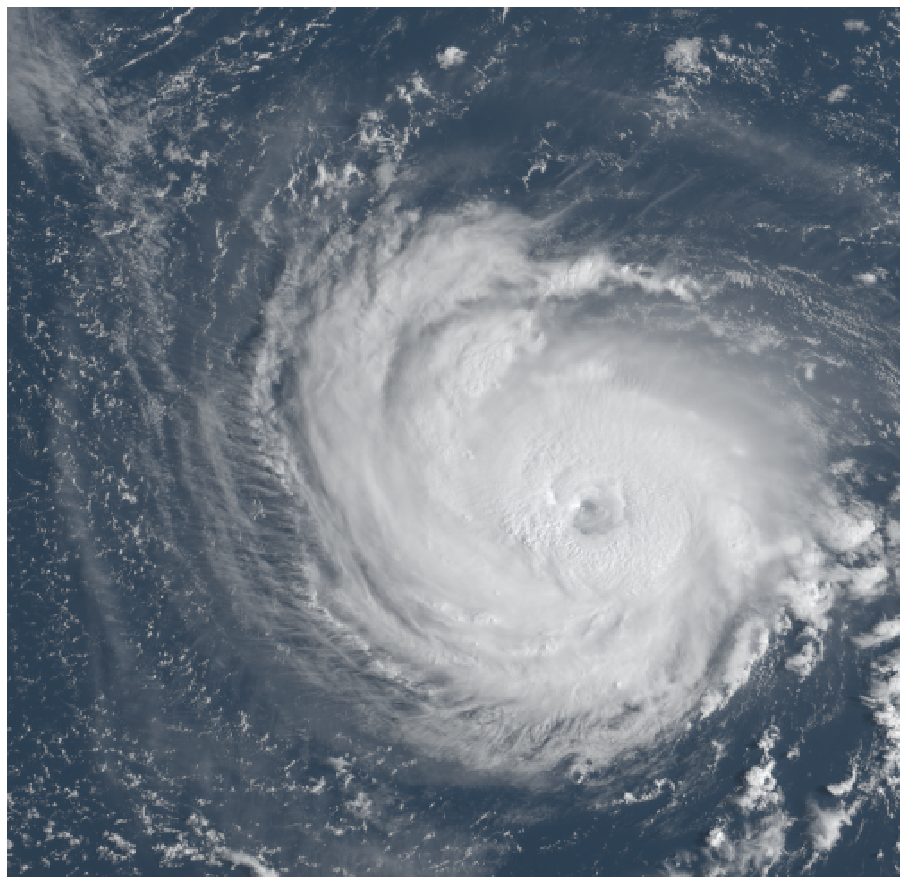

In [36]:
fig, ax = plt.subplots(figsize=(16, 16))
rgb.isel(time=0).plot.imshow(rgb="band", add_labels=False)
ax.set_axis_off()

With this next snippet you can turn this datacube into a movie.

```python
fig, ax = plt.subplots(figsize=(16, 16))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.set_axis_off()

img = rgb[0].plot.imshow(ax=ax, add_colorbar=False, rgb="band", add_labels=False)
label = ax.text(
    0.4,
    0.03,
    pd.Timestamp(rgb.time.data[0]).isoformat(),
    transform=ax.transAxes,
    color="k",
    size=20,
)


def animate(i):
    img.set_data(rgb[i].transpose("y", "x", "band"))
    label.set_text(pd.Timestamp(rgb.time.data[i]).isoformat())
    return img, label


ani = animation.FuncAnimation(fig, animate, frames=len(rgb), interval=120)
ani.save(
    "goes.mp4",
    fps=15,
    extra_args=["-vcodec", "libx264"],
    savefig_kwargs=dict(pad_inches=0, transparent=True),
)
```

<video controls width="80%" src="https://ai4edatasetspublicassets.blob.core.windows.net/assets/pc_video/pc-examples-goes-florence.webm">
</video>

## HRRR example

Through NODD, we also have access to HRRR data in Azure Blob Storage. Converting the GRIB2 files to something like a bunch of COGs or Zarr would not be straightfoward. Can we get the same kind of cloud-native access from the GRIB files?

In [37]:
import adlfs
import cfgrib

import xarray as xr
import datetime as dt
import fsspec
import json
from kerchunk.grib2 import scan_grib
from kerchunk.combine import MultiZarrToZarr
import pathlib
import adlfs
import itertools

fs = adlfs.AzureBlobFileSystem("noaahrrr")
files = fs.ls("hrrr/hrrr.20220601/conus/")
files[-10:]

['hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf14.grib2.idx',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf15.grib2',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf15.grib2.idx',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf16.grib2',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf16.grib2.idx',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf17.grib2',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf17.grib2.idx',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf18.grib2',
 'hrrr/hrrr.20220601/conus/hrrr.t23z.wrfsubhf18.grib2.idx',
 'hrrr/hrrr.20220601/conus/ls-l']

Unfortunately, high-level libraries like `cfgrib` don't necessarily know how to read files over the network.

In [38]:
%xmode plain

Exception reporting mode: Plain


In [39]:
url = f"{fs.account_url}/hrrr/hrrr.20220601/conus/hrrr.t00z.wrfnatf00.grib2"
cfgrib.open_datasets(url)

Can't create file 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20220601/conus/hrrr.t00z.wrfnatf00.grib2.923a8.idx'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/cfgrib/messages.py", line 522, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/srv/conda/envs/notebook/lib/python3.8/contextlib.py", line 113, in __enter__
    return next(self.gen)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/cfgrib/messages.py", line 488, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
FileNotFoundError: [Errno 2] No such file or directory: 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20220601/conus/hrrr.t00z.wrfnatf00.grib2.923a8.idx'
Can't read index file 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20220601/conus/hrrr.t00z.wrfnatf00.grib2.923a8.idx'
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/si

FileNotFoundError: [Errno 2] No such file or directory: 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20220601/conus/hrrr.t00z.wrfnatf00.grib2'

So you would typically need to download the file locally and then read it. But that'd be slow becuase:

1. Disks are relatively slow compared to RAM.
2. GRIB files contain many messages, we might only be interested in some subset.

But suppose a have some magical file, whose structure we'll get into in a second.

In [40]:
%%time
ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    chunks={},
    consolidated=False,
    storage_options=dict(
        fo="references.json",
        remote_protocol="az",
        remote_options={"account_name": "noaahrrr"}
    )
)
ds

CPU times: user 31.4 ms, sys: 8.8 ms, total: 40.2 ms
Wall time: 35.9 ms


<xarray.Dataset>
Dimensions:            (valid_time: 6, x: 1059, y: 1799, heightAboveGround: 1,
                        step: 1, time: 1)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 2
  * step               (step) timedelta64[ns] 01:00:00
  * time               (time) datetime64[ns] 2022-08-30
  * valid_time         (valid_time) datetime64[ns] 2022-08-30T01:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    10si               (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    10u                (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    10v                (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2d                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2r                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2sh                (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2t                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    latitude           (x, y) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude          (x, y) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    pt                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown            (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    centre:             kwbc
    centreDescription:  US National Weather Service - NCEP
    edition:            2
    subCentre:          0

With this dataset, we can subset variables and slice the data. We only end up reading the data we request.

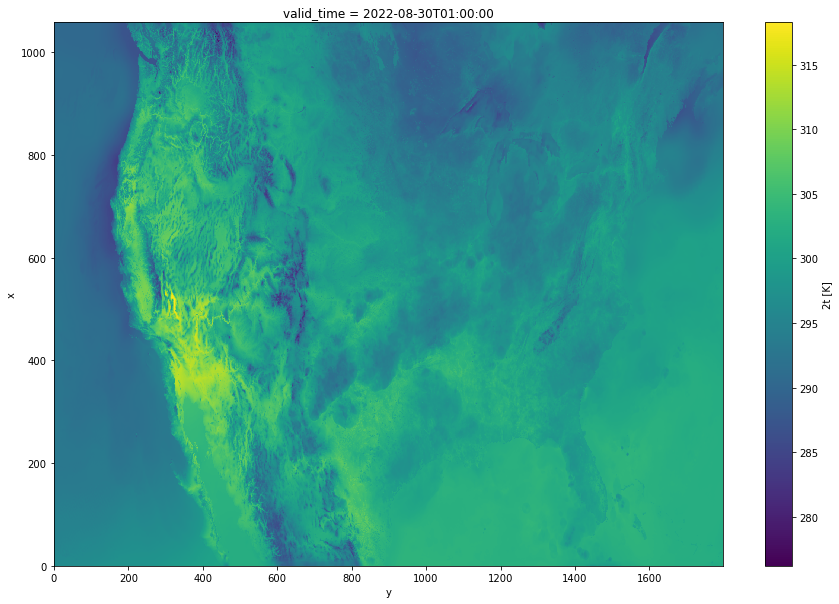

In [41]:
ds["2t"].isel(valid_time=0).plot(size=10);

Or average over space:

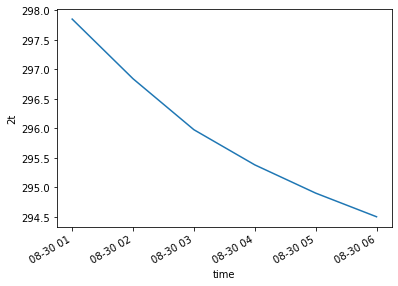

In [42]:
ds["2t"].mean(dim=["x", "y"]).plot();

So what exactly is that magical file?

In [43]:
from IPython.display import JSON

JSON("references.json")

<IPython.core.display.JSON object>

This file is a Kerchunk "index file". It includes a bit of metadata like the dimension names and attributes, but no actual data. Instead, the values look like this:

```json
{
    "refs": {
        ...,
        "2t/0.0.0": ["az://hrrr/hrrr.20220830/conus/hrrr.t00z.wrfsfcf01.grib2", 44995485, 1218950]
        ...
    }
}
```

If your familar with Zarr, the `2t/0.0.0` will look familar. That indicates the first chunk for the group "2t". Typically, the value for that key would be the actual bytes. But for Kerchunk, it's a URL, start byte, and length: just enough information to make an HTTP range request to download that exact subset of data.

In the future, the Planetary Computer will generate these reference files. For now, you can do it yourself:

In [ ]:
remote_storage_options = dict(account_name="noaahrrr")
remote_fs = adlfs.AzureBlobFileSystem(**remote_storage_options)

days_available = remote_fs.ls("hrrr/")
files = sorted(remote_fs.glob(f"{days_available[-1]}/conus/*wrfsfcf01.grib2"))

afilter={'typeOfLevel': 'heightAboveGround', 'level': [2, 10]}    

references = [
    scan_grib(f"az://{f}", storage_options=remote_storage_options, filter=afilter)
    for f in files
]

refs = list(itertools.chain(*references))

mzz = MultiZarrToZarr(
    refs,
    concat_dims = ['valid_time'],
    identical_dims=['latitude', 'longitude', 'heightAboveGround', 'step'],
    remote_protocol="az",
    remote_options=remote_storage_options
)

d = mzz.translate()
pathlib.Path("references.json").write_text(json.dumps(d))

And now we can read that data, via Kerchunk, using xarray.

Index files for GRIB are nothing new. Many NOAA products have them. Many ECMWF products have them. But (as far as I can tell) there isn't a index format, and they're relatively hard to use from high-level tools like xarray.

Calling back to that Paul Ramsey quote: the really hard part of "cloud-optimized" data access in the clients. Zarr already knows how to talk to all these different storage backends (Azure Blob Storage, S3, local), and xarray already knows how to talk to Zarr. Kerchunk is piggybacking on all the work already done to expose these non-cloud-optimized file formats in a cloud-friendly way.